In [15]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import matplotlib.image as img
#import trainCifarStarterCode.py
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
MNIST_data, MNIST_label = mnist.train.next_batch(55000)

In [4]:
# Try implementing MNIST training by myself
# Shuffle the dataset

num_examples = 55000
perm = np.arange(num_examples)
np.random.shuffle(perm)
MNIST_data = MNIST_data[perm, :]
MNIST_label= MNIST_label[perm, :]

def next_batch(x, y, batch_size, index_in_epoch):
    start = index_in_epoch
    index_in_epoch += batch_size
    num_examples = 55000
    if index_in_epoch > num_examples:
        # Shuffle the data
        # perm = np.arange(num_examples)
        # np.random.shuffle(perm)
        # x = x[perm, :]
        # y = y[perm, :]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
    # assert batch_size <= num_examples
    end = index_in_epoch
    return x[start:end, :], y[start:end, :], index_in_epoch

index = 0

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


0.12316927

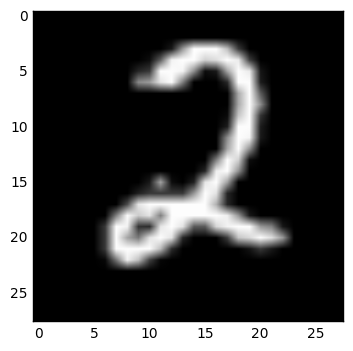

In [9]:
MNIST_sample_data, MNIST_sample_label, index = next_batch(MNIST_data, MNIST_label, 1, index)
MNIST_sample_data = MNIST_sample_data.reshape(28, 28)
print(MNIST_sample_label)
plt.imshow(MNIST_sample_data, cmap = 'gray')
np.mean(MNIST_sample_data.reshape(1, 28*28))

Basic info about MNIST data

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


0.15788318

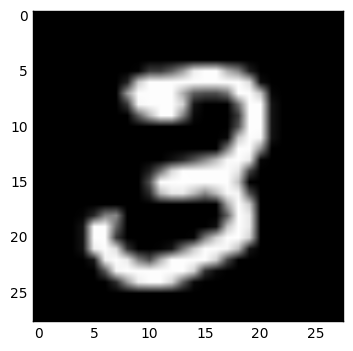

In [58]:
mnist_sample_data, mnist_sample_label = mnist.train.next_batch(1)
mnist_sample_data = mnist_sample_data.reshape(28, 28)
print(mnist_sample_label)
plt.imshow(mnist_sample_data, cmap = 'gray')
np.mean(mnist_sample_data.reshape(1, 28 * 28))

Basic info about CIFAR data

In [31]:
# Load data: Convert .png images in training and testing datasets into addressable matrices.

# Get the current directory for getting the png data
# import os
# cwd = os.getcwd()

ntrain = 1000 # per class
ntest = 100 # per class
nclass = 10 # number of classes
imsize = 28
nchannels = 1  # No color, only grey scale

# Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Train = np.zeros((ntrain*nclass,imsize * imsize))
Test = np.zeros((ntest*nclass,imsize * imsize))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))
itrain = -1
itest = -1

for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = '/notebooks/CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        im = img.imread(path); # 28 by 28
        im = im.astype(float)
        itrain += 1
        # Train[itrain,:,:,0] = im
        im_mean = np.mean(im.reshape(1, imsize * imsize))
        Train[itrain, :] = im.reshape(1, imsize * imsize) -  im_mean 
        LTrain[itrain, iclass] = 1 # 1-hot lable
    for isample in range(0, ntest):
        path = '/notebooks/CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = img.imread(path); # 28 by 28
        im = im.astype(float)
        itest += 1
        # Test[itest,:,:,0] = im
        im_mean = np.mean(im.reshape(1, imsize * imsize))
        Test[itest,:] = im.reshape(1, imsize * imsize) - im_mean 
        LTest[itest,iclass] = 1 # 1-hot lable

# Shuffle the dataset

num_examples = itrain + 1
perm = np.arange(num_examples)
np.random.shuffle(perm)
Train = Train[perm, :]
LTrain = LTrain[perm, :]

def next_batch(x, y, batch_size, index_in_epoch):
    start = index_in_epoch
    index_in_epoch += batch_size
    num_examples = 10000
    if index_in_epoch > num_examples:
        # Shuffle the data
        # perm = np.arange(num_examples)
        # np.random.shuffle(perm)
        # x = x[perm, :]
        # y = y[perm, :]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
    # assert batch_size <= num_examples
    end = index_in_epoch
    return x[start:end, :], y[start:end, :], index_in_epoch

In [21]:
index = 0

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


0.45064526769256563

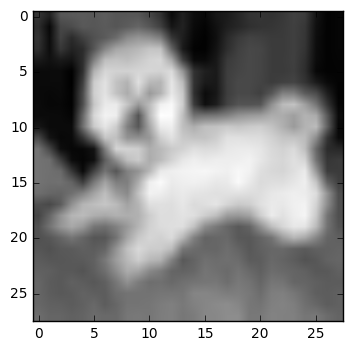

In [28]:
CIFAR10_sample_data, CIFAR10_sample_label, index = next_batch(Train, LTrain, 1, index)
CIFAR10_sample_data = CIFAR10_sample_data.reshape(28, 28)
print(CIFAR10_sample_label)
plt.imshow(CIFAR10_sample_data, cmap = 'gray')
np.mean(CIFAR10_sample_data.reshape(1, 28*28))

In [17]:
# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10
imsize = 28

# Network Parameters
n_input = imsize ** 2 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [18]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [19]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [32]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    index_in_epoch = 0
    while step * batch_size < training_iters:
        # Train CIFAR data
        batch_x, batch_y, index_in_epoch = next_batch(Train, LTrain, batch_size, index_in_epoch)
        # batch_x, batch_y, index_in_epoch = next_batch(MNIST_data, MNIST_label, batch_size, index_in_epoch)
        # batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))
        step += 1
    print ("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    print ("Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob: 1.}))

Iter 1280, Minibatch Loss= 21766.132812, Training Accuracy= 0.12500
Iter 2560, Minibatch Loss= 16462.570312, Training Accuracy= 0.10938
Iter 3840, Minibatch Loss= 14286.873047, Training Accuracy= 0.16406
Iter 5120, Minibatch Loss= 13197.636719, Training Accuracy= 0.22656
Iter 6400, Minibatch Loss= 12359.505859, Training Accuracy= 0.17188
Iter 7680, Minibatch Loss= 9281.880859, Training Accuracy= 0.22656
Iter 8960, Minibatch Loss= 10071.045898, Training Accuracy= 0.21875
Iter 10240, Minibatch Loss= 8276.669922, Training Accuracy= 0.29688
Iter 11520, Minibatch Loss= 6175.881836, Training Accuracy= 0.32031
Iter 12800, Minibatch Loss= 7070.458008, Training Accuracy= 0.23438
Iter 14080, Minibatch Loss= 6619.529297, Training Accuracy= 0.29688
Iter 15360, Minibatch Loss= 5944.014648, Training Accuracy= 0.34375
Iter 16640, Minibatch Loss= 5647.641113, Training Accuracy= 0.29688
Iter 17920, Minibatch Loss= 6305.622070, Training Accuracy= 0.26562
Iter 19200, Minibatch Loss= 6231.287109, Training

KeyboardInterrupt: 

In [8]:
% debug

> /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py(887)_run()
    885                 'Cannot feed value of shape %r for Tensor %r, '
    886                 'which has shape %r'
--> 887                 % (np_val.shape, subfeed_t.name, str(subfeed_t.get_shape())))
    888           if not self.graph.is_feedable(subfeed_t):
    889             raise ValueError('Tensor %s may not be fed.' % subfeed_t)

ipdb> up
> /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py(717)run()
    715       tf_session.TF_DeleteBuffer(run_metadata_ptr)
    716       if options:
--> 717         tf_session.TF_DeleteBuffer(options_ptr)
    718     return result
    719 

ipdb> up
> <ipython-input-7-50c91b58a665>(21)<module>()
     17         step += 1
     18     print ("Optimization Finished!")
     19 
     20     # Calculate accuracy for 256 mnist test images
---> 21     print ("Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], y: m

In [43]:
mnist.train.next_batch(1)[0].shape

(1, 784)